# STA 208: Homework 3 (Do not distribute)

__Instructions:__ Submit it on canvas.  The canvas should include all of your code either in this notebook file, or a separate python file that is imported and ran in this notebook.  We should be able to open this notebook and run everything here by running the cells in sequence.  The written portions can be either done in markdown and TeX in new cells or written clearly by hand when you hand it in.  Submit each file separately.

- Code should be well organized and documented
- All math should be clear and make sense sequentially
- When in doubt explain what is going on
- You will be graded on correctness of your math, code efficiency and succinctness, and conclusions and modelling decisions

__Exercise 1__ (10 pts)

Recall that surrogate losses for large margin classification take the form, $\phi(y_i x_i^\top \beta)$ where $y_i \in \{-1,1\}$ and $\beta, x_i \in \mathbb R^p$.

The following functions are used as surrogate losses for large margin classification.  Demonstrate if they are convex or not, and follow the instructions.

1. exponential loss: $\phi(x) = e^{-x}$
1. truncated quadratic loss: $\phi(x) = (\max\{1-x,0\})^2$
1. hinge loss: $\phi(x) = \max\{1-x,0\}$
1. sigmoid loss: $\phi(x) = 1 - \tanh(\kappa x)$, for fixed $\kappa > 0$
1. Plot these as a function of $x$.

(This problem is due to notes of Larry Wasserman.) 


## Answers to Exercise 1

1. Exponential loss is convex. This is easy to show since the function is twice differentiable. $\frac{d^2}{dx^2} e^{-x} = e^{-x}$. Since the second derivative with respect to x of $e^{-x}$ is $e^{-x}$ and it is positive for all x, we can say that the exponentail loss function is convex. 


2. Applying the same method to the truncated loss function we need to split the function into two parts. We have the function $\phi = (1 - x)^2$, $ x \in (-\infty, 1]$ and $\phi = 0$ , $x \in (1, \infty)$. Taking the second derivative of both funtions we find $\frac{d^2}{dx^2} \phi = 2$, $ x \in (-\infty, 1]$ and $\frac{d^2}{dx^2} \phi = 0$, $ x \in (1, \infty)$. The second derivative of $\phi$ is always greater than or equal to zero proving that the truncated quadratic loss function is convex.


3. Taking the second derivative of the hinge loss, we find that $\frac{d^2}{dx^2} \phi = 0$. This is indicative of a loss function that is both convex and concave, so technically the hinge loss is convex.


4. The second derivative of sigmoid loss I found using wolfram alpha. $\frac{d^2}{dx^2} \phi = 2sech^2(x)tanh(x)$ which is not greater than or equal than zero for all x. The sigmoid loss is only convex on the interval $x \in (0, \infty)$

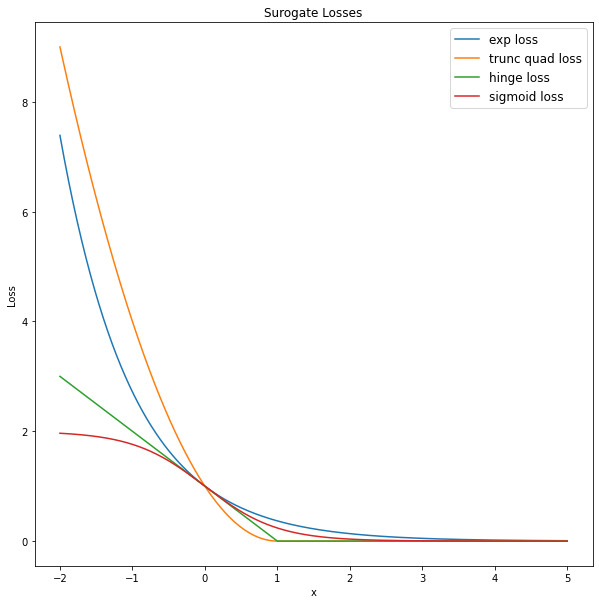

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Define our x array
start = -2
stop = 5
step = 0.01
x = np.arange(start, stop+step, step)

# Exponential loss
exp_loss = np.exp(-x)

# Truncated quadratic loss
quad_loss = 1-x
quad_loss[quad_loss < 0] = 0
quad_loss = quad_loss**2

# Hinge loss
hinge_loss = 1-x
hinge_loss[hinge_loss < 0] = 0

# Sigmoid loss
kappa = 1
sigmoid_loss = 1 - np.tanh(kappa*x)

# Plotting our loss functions
plt.figure(figsize=(10,10))
plt.plot(x, exp_loss, label="exp loss")
plt.plot(x, quad_loss, label="trunc quad loss")
plt.plot(x, hinge_loss, label="hinge loss")
plt.plot(x, sigmoid_loss, label="sigmoid loss")
plt.xlabel("x")
plt.ylabel("Loss")
plt.title("Surogate Losses")
plt.legend(fontsize="large")
plt.show()

__Exercise 2__ (20 pts)

Consider the truncated quadratic loss from (1.1.2).  For brevity let $a_+ = max\{a,0\}$ denote the positive part of $a$.

$$\ell(y_i,x_i,\beta) = \phi(y_i x_i^\top \beta) = (1-y_i x_i^\top \beta)_+^2$$

1. Consider the empirical risk, $R_n$ (the average loss over a training set) for the truncated quadratic loss.  What is gradient of $R_n$ in $\beta$?  Does it always exists?
1. Demonstrate that the gradient does not have continuous derivative everywhere.
1. Recall that support vector machines used the hinge loss $(1 - y_i x_i^\top \beta)_+$ with a ridge regularization.  Write the regularized optimization method for the truncated quadratic loss, and derive the gradient of the regularized empirical risk.
1. In quasi-Newton methods a matrix ($Q$) that is a surrogate for the Hessian of the objective $L$ is used to determine step direction.

$$
\beta \gets \beta - Q^{-1} \nabla L(\beta)
$$


Because the loss does not have continuous Hessian, instead of the Newton method, we will use a quasi-Newton method that replaces the Hessian with a quasi-Hessian (another matrix that is meant to approximate the Hessian).  Consider the following quasi-Hessian of the regularized objective to be $$G(\beta) = \frac 1n \sum_i 2 (x_i x_i^\top 1\{ y_i x_i^\top \beta < 1 \}) + 2 \lambda I.$$  Demonstrate that the quasi-Hessian is positive definite, and write pseudo-code for quasi-Newton optimization, comment on the computational complexity of this method.  (Hint: Solving a system $Qa = b$ for p by p Q matrix takes $O(p^3)$ time)

**Exercise 3 (20 pts)**

Consider the simulation below.

1. Implement minibatch stochastic gradient descent with the truncated quadratic loss using just numpy and base python.  Access the data by iteratively calling the ``sim_data`` method below.  

2. With minibatch size of $1$ (SGD).  Vary the learning schedule to be constant, decaying with $\eta_t \propto t^{-1/2}$, and $\eta_t \propto t^{-1}$.  Compare these schedules using normal noise (the ``noise_dis`` parm).

3. Vary the minibatch size to see the change in performance, with the best learning schedule from 2. When you compare two methods, make sure that you compare them with the same amount of data accessed (so use 1:10 ratio of iterations if you are comparing a minibatch ratio of 10:1).

4. Redo 2, 3 with ``noise_dis`` set to ``"chisquare"``.

In [3]:
import numpy as np

In [4]:
class DataSimulator:
    """
    Simulate the data for linear classification
    """
    def __init__(self,p,noise_dist = "normal"):
        self.beta = np.random.normal(0,1,p)
        self.noise_dist = noise_dist
        self.p = p
        
    def sim_data(self,m = 1):
        p = self.p
        X = np.random.normal(0,1,(m,p))
        if self.noise_dist == "normal":
            eps = np.random.normal(0,1,m)
        if self.noise_dist == "chisquare":
            eps = np.random.chisquare(1,m)
        z = X @ self.beta + eps
        y = 2*(z > 0)-1
        return X, y

In [5]:
ds = DataSimulator(10)
ds.sim_data(m=10)

(array([[ 0.17459256, -0.5950664 ,  0.14164875,  1.00789915,  1.52097789,
         -2.35292289, -0.50395825, -0.2364724 ,  1.05704893, -0.85057724],
        [ 2.24071163, -0.55677462, -0.87292496, -2.01811478,  0.31402302,
          1.08389045, -1.04015489, -0.4591674 , -0.84599752, -2.03291433],
        [ 0.65142912,  0.51700884, -0.56405856,  0.25018309,  0.27288681,
         -2.39893734, -1.26470106,  0.08149991, -0.2103138 , -1.92803075],
        [-1.07546376, -0.12527754, -0.04904566,  0.63236309,  0.16898363,
         -0.49714911, -0.07328165,  1.09958584,  0.30888407, -0.76970409],
        [ 1.91230717,  0.67838713, -0.97439855, -0.72950593, -0.50834705,
         -0.34413199, -0.40604259, -0.89565974,  1.17803265,  0.80007911],
        [-0.91934717, -1.15178371, -1.63185586,  0.4312865 ,  0.08805506,
         -0.78994413, -0.33735674, -0.85196559, -0.63270512, -0.01627497],
        [ 0.36672325,  0.87293361, -0.62322003, -0.72003159, -0.18015153,
          0.01737342, -0.2565023

In [ ]:
def grad_descent(ds,T,m,beta_start,C,gamma):
    """
    ds: data simulator
    T: number of iterations
    m: minibatch size
    beta_start: init beta
    C, gamma : eta_t = C t^(-gamma)
    """
    losses = [] # tracks loss at each time
    betas = [] # tracks betas at each time
    
    ...
    
    return(betas,losses)

perf = [np.sum((beta- beta_true)**2) for beta in betas]
plt.plot(np.arange(T)*m, perf)

__Exercise 4.__ (50 pts) 

Text data can be converted into vector data through a vectorization operation.  A corpus is a collection of documents and the dictionary is all of the words in the corpus.  Bag-of-words models will treat each document as a set of words, ignoring the order of the words.  Then a simple vectorizer will let $X_{i,j}$ be the number of times the $j$th word is in the $i$th document.  Two vectorizers are ``sklearn.feature_extraction.text.CountVectorizer`` and ``sklearn.feature_extraction.text.TfidfVectorizer``.

Below is an import of a reuters dataset.  I have written a def to process a single file.  Construct a response variable that has three categories, if the topic is 'earn', 'acq', or another category.  Import all of the data and construct two sparse vectorized matrices---look at ``scipy.sparse``---based on the two above vectorizations.  Use sklearn svm.SVC on the TRAIN split and predict on the TEST split.  Plot your ROC and PR curves for predicting 'earn' (versus everything else); use the linear kernel and tune the C parameter.  Do the same for predicting 'acq' versus everything else.  Write a paragraph summarizing the performance and tuning.

In [6]:
from lxml import html, etree

In [7]:
reu = html.parse("reuters/reut2-000.sgm") #You will have to do this for all sgm files here

In [8]:
import nltk
nltk.download()
# Download Corpora -> stopwords, Models -> punkt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


In [9]:
def parse_reu(reu):
    """Parses the etree object and returns a list of dictionary of reuters attr
    Output: {'topics': the topic of the article, 'places': where it is located, 
        'split': training/test split, 'body':the text of the article as a set of words with stopwords removed}
    """
    root= reu.getroot()
    articles = root.body.getchildren()
    stop_words = set(stopwords.words('english'))
    reu_pl = []
    for a in articles:
        reu_parse = {}
        if a.attrib['topics'] != 'YES':
            next
        topics = a.find('topics').findall('d')
        if topics:
            reu_parse['topics'] = [t.text for t in topics]
        else:
            reu_parse['topics'] = []
        places = a.find('places').findall('d')
        if places:
            reu_parse['places'] = [t.text for t in places]
        reu_parse['split'] = a.attrib['lewissplit']
        rtxt = a.find('text')
        word_tokens = word_tokenize(rtxt.text_content())
        filtered_sentence = set([w.lower() for w in word_tokens if not w in stop_words])
        reu_parse['body'] = filtered_sentence
        reu_pl.append(reu_parse)
    return reu_pl

In [10]:
reu_pl = parse_reu(reu)

In [11]:
print(reu_pl[0]['topics'])
" ".join(reu_pl[0]['body'])

['cocoa']


'currency currently stage fit april/may quality although spot +bahia 2,325 reuter doubts also light normal argentina year 350 going 27 26 available processors 1,880 1,870 alleviating july continued went weekly 2,380 covertible selling 995 nearby bags dec cumulative 2.27 oct/dec convertible would still prices 1.25 shippers 15 drought again limited 22 ports 6.13 bahia january review farmers buyers 4,450 making rose march/april coming may much end included 1.06 6.4 june/july ended u.s. published good 785 harvesting certificates fob - 1,850 carnival throughout early 1,875 comissaria shipment uruguay part reluctant 28 6.2 middlemen salvador superior+ 340 lower held registered estimated improving 4,400 york times dry 2,400 week levels arrivals booked 4,340 come trade showers mln dificulties almost march commission feb practically sept 155,221 doubt 5.81 smith estimates 0.39 1986/87 5.93 ends 2.28 4,480 obtaining temporao february around cocoa standing crop late said recent weeks 45 liquor th